# Stacking

In stacking one blends the predictions of different regressors or classifiers to gain, in some cases, better performance than naive averaging or majority vote.
Here we illustrate how to build a two-model stack as an MLJ learning network, which we export as a new stand-alone composite model type MyTwoStack. This will make the stack that we build completely re-usable (new data, new models). This means we can apply meta-algorithms, such as performance evaluation and tuning, to the stack, exactly as we would for any other model.

Our main purpose here is to demonstrate the flexibility of MLJ's composite model interface. Eventually, MLJ will provide built-in composite types or macros to achieve the same results in a few lines, which will suffice for routine stacking tasks.

In [2]:
using MLJ
using PyPlot
using StableRNGs

In [5]:
linear = @load LinearRegressor pkg=MLJLinearModels

import MLJLinearModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/sandhya/.julia/packages/MLJModels/E8BbE/src/loading.jl:168


MLJLinearModels.LinearRegressor

In [6]:
knn = @load KNNRegressor; knn(K = 4)

import NearestNeighborModels ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/sandhya/.julia/packages/MLJModels/E8BbE/src/loading.jl:168


KNNRegressor(
    K = 4,
    algorithm = :kdtree,
    metric = Distances.Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = NearestNeighborModels.Uniform()) @974

In [7]:
tree_booster = @load EvoTreeRegressor; tree_booster(nrounds = 100)

import EvoTrees ✔


┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/sandhya/.julia/packages/MLJModels/E8BbE/src/loading.jl:168


EvoTreeRegressor(
    loss = EvoTrees.Linear(),
    nrounds = 100,
    λ = 0.0,
    γ = 0.0,
    η = 0.1,
    max_depth = 5,
    min_weight = 1.0,
    rowsample = 1.0,
    colsample = 1.0,
    nbins = 64,
    α = 0.5,
    metric = :mse,
    rng = MersenneTwister(444),
    device = "cpu") @992

In [8]:
forest = @load RandomForestRegressor pkg=DecisionTree; forest(n_trees = 500)

import MLJDecisionTreeInterface ✔

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/sandhya/.julia/packages/MLJModels/E8BbE/src/loading.jl:168


RandomForestRegressor(
    max_depth = -1,
    min_samples_leaf = 1,
    min_samples_split = 2,
    min_purity_increase = 0.0,
    n_subfeatures = -1,
    n_trees = 500,
    sampling_fraction = 0.7,
    pdf_smoothing = 0.0) @359

In [9]:
svm = @load SVMRegressor;

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main /home/sandhya/.julia/packages/MLJModels/E8BbE/src/loading.jl:168


import MLJScikitLearnInterface ✔


### Warm-up exercise: Define a model type to average predictions

In [11]:
X = source()
y = source()


Source @796 ⏎ `Nothing`

In [16]:
X

Source @511 ⏎ `Nothing`

In [17]:
model1 = linear()
model2 = knn()


KNNRegressor(
    K = 5,
    algorithm = :kdtree,
    metric = Distances.Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = NearestNeighborModels.Uniform()) @343

In [18]:
m1 = machine(model1, X, y)
y1 = predict(m1, X)


Node{Machine{LinearRegressor,…}} @592
  args:
    1:	Source @511
  formula:
    predict(
        Machine{LinearRegressor,…} @296, 
        Source @511)

In [19]:

m2 = machine(model2, X, y)
y2 = predict(m2, X)

yhat = 0.5*y1 + 0.5*y2

Node{Nothing} @617
  args:
    1:	Node{Nothing} @830
    2:	Node{Nothing} @033
  formula:
    +(
        #129(
            predict(
                Machine{LinearRegressor,…} @296, 
                Source @511)),
        #129(
            predict(
                Machine{KNNRegressor,…} @860, 
                Source @511)))

In [20]:
mach = machine(Deterministic(), X, y; predict=yhat)

Machine{DeterministicSurrogate,…} @492 trained 0 times; does not cache data
  args: 
    1:	Source @511 ⏎ `Nothing`
    2:	Source @796 ⏎ `Nothing`


In [21]:
@from_network mach begin
    mutable struct MyAverageTwo
        regressor1=model1
        regressor2=model2
    end
end

In [22]:
average_two = MyAverageTwo()

MyAverageTwo(
    regressor1 = LinearRegressor(
            fit_intercept = true,
            solver = nothing),
    regressor2 = KNNRegressor(
            K = 5,
            algorithm = :kdtree,
            metric = Distances.Euclidean(0.0),
            leafsize = 10,
            reorder = true,
            weights = NearestNeighborModels.Uniform())) @728

In [24]:
function print_performance(model, data...)
    e = evaluate(model, data...;
                 resampling=CV(rng=StableRNG(1234), nfolds=8),
                 measure=rms,
                 verbosity=0)
    μ = round(e.measurement[1], sigdigits=5)
    ste = round(std(e.per_fold[1])/sqrt(8), digits=5)
    println("$model = $μ ± $(2*ste)")
end;

X, y = @load_boston

print_performance(linear(), X, y)
print_performance(knn(), X, y)
print_performance(average_two, X, y)

LinearRegressor @383 = 4.8635 ± 0.34864
KNNRegressor @989 = 6.2243 ± 0.44292
MyAverageTwo @728 = 4.8523 ± 0.36264


## Stacking proper

In [27]:
folds(data, nfolds) =
    partition(1:nrows(data), (1/nfolds for i in 1:(nfolds-1))...);

In [28]:
f = folds(1:10, 3)

([1, 2, 3], [4, 5, 6], [7, 8, 9, 10])

In [29]:
corestrict(string.(1:10), f, 2)

7-element Vector{String}:
 "1"
 "2"
 "3"
 "7"
 "8"
 "9"
 "10"

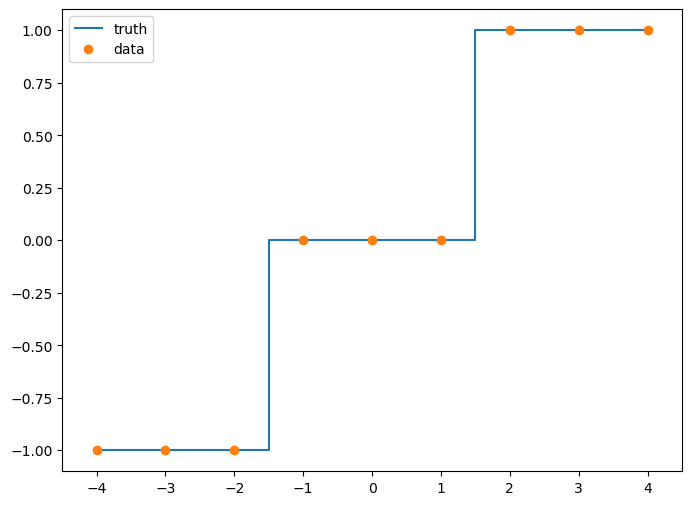

PyObject <matplotlib.legend.Legend object at 0x7f86d836b6d0>

In [30]:
figure(figsize=(8,6))
steps(x) = x < -3/2 ? -1 : (x < 3/2 ? 0 : 1)
x = Float64[-4, -1, 2, -3, 0, 3, -2, 1, 4]
Xraw = (x = x, )
yraw = steps.(x);
idxsort = sortperm(x)
xsort = x[idxsort]
ysort = yraw[idxsort]
step(xsort, ysort, label="truth", where="mid")
plot(x, yraw, ls="none", marker="o", label="data")
xlim(-4.5, 4.5)
legend()

In [31]:
model1 = linear()
model2 = knn()

KNNRegressor(
    K = 5,
    algorithm = :kdtree,
    metric = Distances.Euclidean(0.0),
    leafsize = 10,
    reorder = true,
    weights = NearestNeighborModels.Uniform()) @594

In [32]:
judge = linear()

LinearRegressor(
    fit_intercept = true,
    solver = nothing) @926

In [33]:
X = source(Xraw)
y = source(yraw)

Source @442 ⏎ `AbstractVector{Count}`

In [34]:
f = @node folds(X, 3)

Node{Nothing} @850
  args:
    1:	Source @736
  formula:
    #14(
        Source @736)

In [35]:
f()

([1, 2, 3], [4, 5, 6], [7, 8, 9])

In [36]:
folds(X::AbstractNode, nfolds) = node(XX->folds(XX, nfolds), X)
f = folds(X, 3)
f()

([1, 2, 3], [4, 5, 6], [7, 8, 9])

In [37]:
MLJ.restrict(X::AbstractNode, f::AbstractNode, i) =
    node((XX, ff) -> restrict(XX, ff, i), X, f);
MLJ.corestrict(X::AbstractNode, f::AbstractNode, i) =
    node((XX, ff) -> corestrict(XX, ff, i), X, f);

In [38]:
m11 = machine(model1, corestrict(X, f, 1), corestrict(y, f, 1))
m12 = machine(model1, corestrict(X, f, 2), corestrict(y, f, 2))
m13 = machine(model1, corestrict(X, f, 3), corestrict(y, f, 3))

Machine{LinearRegressor,…} @333 trained 0 times; caches data
  args: 
    1:	Node{Nothing} @146
    2:	Node{Nothing} @902


In [39]:
y11 = predict(m11, restrict(X, f, 1));
y12 = predict(m12, restrict(X, f, 2));
y13 = predict(m13, restrict(X, f, 3));

In [40]:
y1_oos = vcat(y11, y12, y13);

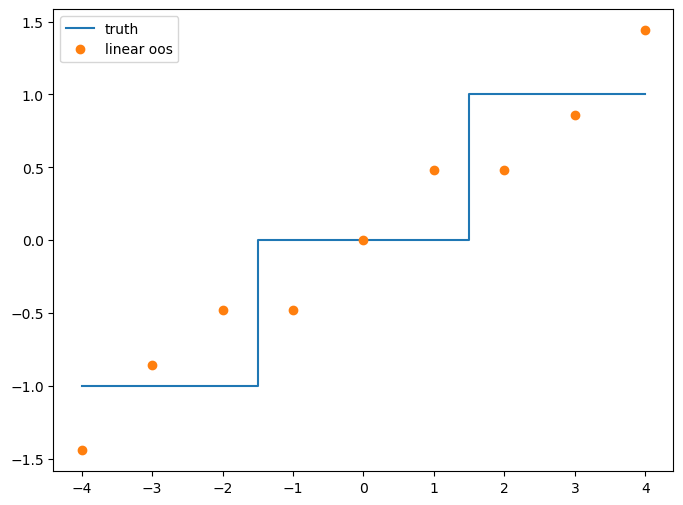

PyObject <matplotlib.legend.Legend object at 0x7f86cf61fb50>

In [42]:
MLJ.fit!(y1_oos, verbosity=0)

figure(figsize=(8,6))
step(xsort, ysort, label="truth", where="mid")
plot(x, y1_oos(), ls="none", marker="o", label="linear oos")
legend()

In [44]:
m21 = machine(model2, corestrict(X, f, 1), corestrict(y, f, 1))
m22 = machine(model2, corestrict(X, f, 2), corestrict(y, f, 2))
m23 = machine(model2, corestrict(X, f, 3), corestrict(y, f, 3))
y21 = predict(m21, restrict(X, f, 1));
y22 = predict(m22, restrict(X, f, 2));
y23 = predict(m23, restrict(X, f, 3));

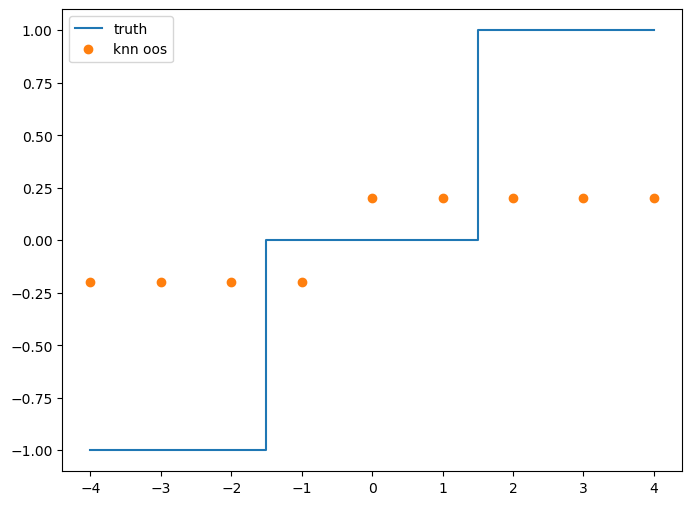

PyObject <matplotlib.legend.Legend object at 0x7f86c45de350>

In [45]:
y2_oos = vcat(y21, y22, y23);
fit!(y2_oos, verbosity=0)

figure(figsize=(8,6))
step(xsort, ysort, label="truth", where="mid")
plot(x, y2_oos(), ls="none", marker="o", label="knn oos")
legend()

In [46]:
X_oos = MLJ.table(hcat(y1_oos, y2_oos))
m_judge = machine(judge, X_oos, y)

Machine{LinearRegressor,…} @970 trained 0 times; caches data
  args: 
    1:	Node{Nothing} @829
    2:	Source @442 ⏎ `AbstractVector{Count}`


In [47]:
m1 = machine(model1, X, y)
m2 = machine(model2, X, y)

Machine{KNNRegressor,…} @560 trained 0 times; caches data
  args: 
    1:	Source @736 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @442 ⏎ `AbstractVector{Count}`


## Define nodes still needed for prediction

In [48]:
y1 = predict(m1, X);
y2 = predict(m2, X);
X_judge = MLJ.table(hcat(y1, y2))
yhat = predict(m_judge, X_judge)

Node{Machine{LinearRegressor,…}} @260
  args:
    1:	Node{Nothing} @174
  formula:
    predict(
        Machine{LinearRegressor,…} @970, 
        table(
            hcat(
                predict(
                    Machine{LinearRegressor,…} @000, 
                    Source @736),
                predict(
                    Machine{KNNRegressor,…} @560, 
                    Source @736))))

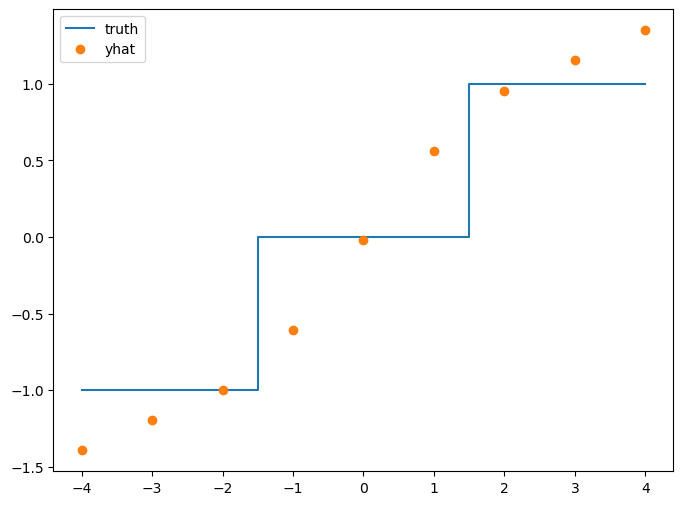

PyObject <matplotlib.legend.Legend object at 0x7f86c451b650>

In [49]:
MLJ.fit!(yhat, verbosity=0)

figure(figsize=(8,6))
step(xsort, ysort, label="truth", where="mid")
plot(x, yhat(), ls="none", marker="o", label="yhat")
legend()

In [50]:
e1 = rms(y1(), y())
e2 = rms(y2(), y())
emean = rms(0.5*y1() + 0.5*y2(), y())
estack = rms(yhat(), y())
@show e1 e2 emean estack;

e1 = 0.2581988897471611
e2 = 0.3771236166328254
emean = 0.2808716591058786
estack = 0.3373908215636328


## Export the learning network as a new model type

In [51]:
@from_network machine(Deterministic(), X, y; predict=yhat) begin
    mutable struct MyTwoModelStack
        regressor1=model1
        regressor2=model2
        judge=judge
    end
end

my_two_model_stack = MyTwoModelStack()

MyTwoModelStack(
    regressor1 = LinearRegressor(
            fit_intercept = true,
            solver = nothing),
    regressor2 = KNNRegressor(
            K = 5,
            algorithm = :kdtree,
            metric = Distances.Euclidean(0.0),
            leafsize = 10,
            reorder = true,
            weights = NearestNeighborModels.Uniform()),
    judge = LinearRegressor(
            fit_intercept = true,
            solver = nothing)) @458

## Applying MyTwoModelStack to some data

In [52]:
X, y = make_regression(1000, 20; sparse=0.75, noise=0.1, rng=123);

In [87]:
avg = MyAverageTwo(regressor1=tree_booster(),
                   regressor2=svm())

MyAverageTwo(
    regressor1 = EvoTreeRegressor(
            loss = EvoTrees.Linear(),
            nrounds = 10,
            λ = 0.0,
            γ = 0.0,
            η = 0.1,
            max_depth = 5,
            min_weight = 1.0,
            rowsample = 1.0,
            colsample = 1.0,
            nbins = 64,
            α = 0.5,
            metric = :mse,
            rng = MersenneTwister(444),
            device = "cpu"),
    regressor2 = SVMRegressor(
            kernel = "rbf",
            degree = 3,
            gamma = "auto",
            coef0 = 0.0,
            tol = 0.001,
            C = 1.0,
            epsilon = 0.1,
            shrinking = true,
            cache_size = 200,
            max_iter = -1)) @010

In [92]:

stack = MyTwoModelStack(regressor1=tree_booster(),
                        regressor2=svm(),
                        judge=forest()) # judge=linear


MyTwoModelStack(
    regressor1 = EvoTreeRegressor(
            loss = EvoTrees.Linear(),
            nrounds = 10,
            λ = 0.0,
            γ = 0.0,
            η = 0.1,
            max_depth = 5,
            min_weight = 1.0,
            rowsample = 1.0,
            colsample = 1.0,
            nbins = 64,
            α = 0.5,
            metric = :mse,
            rng = MersenneTwister(444),
            device = "cpu"),
    regressor2 = SVMRegressor(
            kernel = "rbf",
            degree = 3,
            gamma = "auto",
            coef0 = 0.0,
            tol = 0.001,
            C = 1.0,
            epsilon = 0.1,
            shrinking = true,
            cache_size = 200,
            max_iter = -1),
    judge = RandomForestRegressor(
            max_depth = -1,
            min_samples_leaf = 1,
            min_samples_split = 2,
            min_purity_increase = 0.0,
            n_subfeatures = -1,
            n_trees = 10,
            sampling_fraction = 0.7,
  

In [79]:
all_models = [tree_booster, svm, forest, avg, stack];

for model in all_models
    print_performance(model, X, y)
end

LoadError: syntax: unexpected comma in matrix expression

In [81]:
print_performance(tree_booster(), X, y)

EvoTreeRegressor{Float64,…} @901 = 1.9195 ± 0.044


In [89]:
print_performance(svm(), X, y)

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

SVMRegressor @498 = 0.93596 ± 0.06682


In [84]:
print_performance(forest(), X, y)

RandomForestRegressor @308 = 1.7222 ± 0.05808


In [88]:
print_performance(avg, X, y)

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

MyAverageTwo @010 = 1.31 ± 0.06502


In [93]:
print_performance(stack, X, y)

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

MyTwoModelStack @962 = 0.88208 ± 0.06316


## Tuning a stack

In [94]:
r = range(stack, :(regressor2.C), lower = 0.01, upper = 10, scale=:log)
tuned_stack = TunedModel(model=stack,
                         ranges=r,
                         tuning=Grid(shuffle=false),
                         measure=rms,
                         resampling=Holdout())

mach = fit!(machine(tuned_stack,  X, y), verbosity=0)
best_stack = fitted_params(mach).best_model
best_stack.regressor2.C

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Excessive output truncated after 534172 bytes.

1.0000000000000002

In [95]:
print_performance(best_stack, X, y)

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

Internal error: encountered unexpected error in runtime:
TypeError(func=:CategoricalValue, context="T", expected=T<:Union{AbstractChar, AbstractString, Number}, got=Any)
jl_type_error_rt at /buildworker/worker/package_linux64/build/src/rtutils.c:119
check_datatype_parameters at /buildworker/worker/package_linux64/build/src/jltypes.c:1071
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1278
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1686
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1678
inst_type_w_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1638
jl_instantiate_unionall at /buildworker/worker/package_linux64/build/src/jltypes.c:898
normalize_unionalls at /buildworker/worker/package_linux64/build/src/jltypes.c:1204
inst_datatype_inner at /buildworker/worker/package_linux64/build/src/jltypes.c:1221
jl_apply_tuple_type_v_ at /buildworker/worker/package_linux64/build/src/jltypes.c:1480 [in

MyTwoModelStack @991 = 0.85714 ± 0.07702
